# TFG Migración y turismo inteligente.

Modelos de IA para análisis y visualización. 

## 1. Manejo y tratamiento de dataset

El dataset descargado de la pagina https://ine.es/jaxiT3/Tabla.htm?t=13884 en formato .csv, tiene un peso de 33GB.

El dataset permite consultar datos mensuales sobre turistas internacionales que visitan España. Las variables que se pueden seleccionar para filtrar o clasificar los datos son:

* Vía de acceso: Medio por el cual los turistas entraron al país (aéreo, terrestre, marítimo, etc.).

* Comunidad Autónoma de destino: Región principal que visitaron los turistas.

* País de residencia: Nacionalidad o país de origen de los turistas.

* Motivo del viaje: Razón principal del desplazamiento (ocio, negocios, visitas familiares, etc.).

* Tipo de alojamiento: Categoría del alojamiento utilizado (hotel, vivienda propia, alquiler, etc.).

* Forma de organización del viaje: Si el viaje fue organizado por agencia, paquete turístico, o de forma independiente.

* Duración del viaje: Número de noches que duró la estancia.

* Periodo: Mes y año de referencia de los datos.

Para su manejo en memoria se ha utilizado la libreria duckdb y pasado a formato .parquet reduciendose el tamaño a 48.1 MB

 * Bantra, A. (s. f.). Using DuckDB in Python: A comprehensive guide. Medium. Recuperado de https://medium.com/@anshubantra/using-duckdb-in-python-a-comprehensive-guide-d14bc0b06546
 * Rodríguez, F. [KeepCoding]. (2025, 10 de julio). Tutorial DuckDB Python: Aprende a usarlo paso a paso de forma fácil y rápida. KeepCoding. Recuperado de https://keepcoding.io/blog/duckdb-python-como-usarlo/

In [3]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
# Crear conexión
#con = duckdb.connect()

# Leer directamente el CSV pero sin cargarlo en RAM
#con.execute(r"""
#COPY (SELECT * FROM 'C:\Users\socor\Downloads\13884.csv')
#TO 'C:\Users\socor\Downloads\13884.parquet' (FORMAT 'parquet');
#""")

Una vez transformado en .parquet, se realiza el análisis exploratorío del mismo.

## EDA

In [17]:
archivo = "13884.parquet"
con = duckdb.connect()

#Observamos las columnas y su formato
df_info = con.execute(f"SELECT * FROM read_parquet('{archivo}') LIMIT 1").df().dtypes.reset_index()
df_info.columns = ['columna', 'tipo']
df_info

,columna,tipo
0,Vía de acceso,object
1,Comunidad autónoma de destino,object
2,Motivo del viaje,object
3,Tipo de alojamiento,object
4,Forma de organización del viaje,object
5,Duración del viaje,object
6,País de residencia,object
7,Periodo,object
8,Total,object


Se observa que todas las columnas son de tipo object.

In [19]:
# Conuslta de número de filas, nulos, únicos y cantidad de variables categóricas.

query = f"""
SELECT
    COUNT(*) AS total_filas,
    COUNT(DISTINCT "Vía de acceso") AS vias_unicas,
    COUNT(DISTINCT "Comunidad autónoma de destino") AS comunidades_unicas,
    COUNT(DISTINCT "Motivo del viaje") AS motivos_unicos,
    COUNT(DISTINCT "Tipo de alojamiento") AS alojamientos_unicos,
    COUNT(DISTINCT "Forma de organización del viaje") AS formas_organizacion,
    COUNT(DISTINCT "Duración del viaje") AS duraciones_unicas,
    COUNT(DISTINCT "País de residencia") AS paises_unicos,
    COUNT(DISTINCT Periodo) AS periodos_unicos,
    COUNT(DISTINCT Total) AS total_unicos,
    COUNT(Total) AS total_no_nulo
FROM parquet_scan('{archivo}')
"""

resumen_df = con.execute(query).fetchdf()
display(resumen_df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,total_filas,vias_unicas,comunidades_unicas,motivos_unicos,alojamientos_unicos,formas_organizacion,duraciones_unicas,paises_unicos,periodos_unicos,total_unicos,total_no_nulo
0,239520240,5,18,4,9,3,6,37,111,233002,17443428


El dataset cuenta con casi 239 millones de filas.
El número de variables categóricas coincide con las expuestas en la página web

In [21]:
# Realizamos exploración de los valores de las columnas categoricas.
columnas = [
    "Vía de acceso",
    "Comunidad autónoma de destino",
    "Motivo del viaje",
    "Tipo de alojamiento",
    "Forma de organización del viaje",
    "Duración del viaje",
    "País de residencia"
]

for col in columnas:
    print(f"\nValores únicos de '{col}':")
    query = f"""
        SELECT DISTINCT "{col}"
        FROM parquet_scan('{archivo}')
        ORDER BY 1
    """
    resultado = con.execute(query).fetchdf()
    display(resultado)

# Exploramos tambien valores no numericos en columna total
print("\nValores no numéricos en 'Total':")
query_total_non_numeric = f"""
SELECT DISTINCT Total
FROM parquet_scan('{archivo}')
WHERE NOT regexp_matches(Total, '^[0-9]+([.,][0-9]+)?$')
   OR Total IS NULL
ORDER BY 1
"""
total_non_numeric = con.execute(query_total_non_numeric).fetchdf()
display(total_non_numeric)


Valores únicos de 'Vía de acceso':


,Vía de acceso
0,Aeropuerto
1,Carretera
2,Puerto
3,Total de vías de acceso
4,Tren



Valores únicos de 'Comunidad autónoma de destino':


,Comunidad autónoma de destino
0,01 Andalucía
1,02 Aragón
2,"03 Asturias, Principado de"
3,"04 Balears, Illes"
4,05 Canarias
5,06 Cantabria
6,07 Castilla y León
7,08 Castilla - La Mancha
8,09 Cataluña
9,10 Comunitat Valenciana



Valores únicos de 'Motivo del viaje':


,Motivo del viaje
0,Negocios y otros motivos profesionales
1,"Ocio, recreo y vacaciones"
2,Otros motivos
3,Total de motivos del viaje



Valores únicos de 'Tipo de alojamiento':


,Tipo de alojamiento
0,De mercado
1,Hotelero
2,No de mercado
3,Resto de mercado
4,Resto de no mercado
5,Total de tipos de alojamiento
6,Vivienda de familiares o amigos
7,Vivienda en alquiler
8,Vivienda en propiedad



Valores únicos de 'Forma de organización del viaje':


,Forma de organización del viaje
0,Con paquete turístico
1,Sin paquete turístico
2,Total de formas de organización del viaje



Valores únicos de 'Duración del viaje':


,Duración del viaje
0,1 noche
1,De 2 a 3 noches
2,De 4 a 7 noches
3,De 8 a 15 noches
4,Más de 15 noches
5,Total noches



Valores únicos de 'País de residencia':


,País de residencia
0,Alemania
1,Arabia Saudí
2,Argentina
3,Austria
4,Brasil
5,Bélgica
6,Canadá
7,Chile
8,China
9,Corea



Valores no numéricos en 'Total':


,Total
0,.
1,..
2,1.000.055
3,1.000.109
4,1.000.170
...,...
11377,9.595.136
11378,9.596.016
11379,9.873.270
11380,9.903.485


Se observa que los valores categóricos coinciden con los expuestos en la pagina.

Respecto a total, vemos valores como "." o "..", ademas de nulos.

In [23]:
query = f"""
SELECT
    CASE
        WHEN Total IS NULL THEN 'null'
        WHEN Total = '.' THEN 'punto'
        WHEN Total = '..' THEN 'dos puntos'
        WHEN TRY_CAST(REPLACE(Total, '.', '') AS BIGINT) IS NOT NULL THEN 'numérico'
        ELSE 'otro'
    END AS categoria_total,
    COUNT(*) AS conteo
FROM parquet_scan('{archivo}')
GROUP BY categoria_total
ORDER BY conteo DESC
"""

df_resultado = con.execute(query).fetchdf()
display(df_resultado)

,categoria_total,conteo
0,null,222076812
1,punto,16143681
2,numérico,1299466
3,dos puntos,281


De los 239 millones de filas que teniamos, se observa que solo 1.2 millones contienen datos numericos en el campo total que puedan servir para análisis.

En el siguiente paso, quiero observar si los valores numéricos corresponden con filas completas o con agregaciones, es decir, si esas mismas filas tienen algun valor tipo "Total" o "Todos" en otras columnas (lo que sugeriría que son agregaciones, no registros "normales").

In [25]:
query_agregaciones_en_numericos = f"""
SELECT
    "Vía de acceso",
    "Comunidad autónoma de destino",
    "Motivo del viaje",
    "Tipo de alojamiento",
    "Forma de organización del viaje",
    "Duración del viaje",
    "País de residencia",
    COUNT(*) AS num_filas
FROM (
    SELECT *
    FROM parquet_scan('{archivo}')
    WHERE TRY_CAST(REPLACE(Total, '.', '') AS BIGINT) IS NOT NULL
)
WHERE
    LOWER("Vía de acceso") LIKE '%total%' OR
    LOWER("Comunidad autónoma de destino") LIKE '%total%' OR
    LOWER("Motivo del viaje") LIKE '%total%' OR
    LOWER("Tipo de alojamiento") LIKE '%total%' OR
    LOWER("Forma de organización del viaje") LIKE '%total%' OR
    LOWER("Duración del viaje") LIKE '%total%' OR
    LOWER("País de residencia") LIKE '%total%'
GROUP BY ALL
ORDER BY num_filas DESC
"""

agregaciones_detectadas = con.execute(query_agregaciones_en_numericos).fetchdf()
display(agregaciones_detectadas)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Vía de acceso,Comunidad autónoma de destino,Motivo del viaje,Tipo de alojamiento,Forma de organización del viaje,Duración del viaje,País de residencia,num_filas
0,Total de vías de acceso,Total nacional,Negocios y otros motivos profesionales,Total de tipos de alojamiento,Total de formas de organización del viaje,Total noches,Total país de residencia,109
1,Total de vías de acceso,Total nacional,Total de motivos del viaje,Hotelero,Total de formas de organización del viaje,Total noches,Italia,109
2,Aeropuerto,Total nacional,Otros motivos,Total de tipos de alojamiento,Total de formas de organización del viaje,De 4 a 7 noches,Total país de residencia,109
3,Aeropuerto,01 Andalucía,Total de motivos del viaje,Vivienda de familiares o amigos,Total de formas de organización del viaje,Total noches,Total país de residencia,109
4,Aeropuerto,Total nacional,"Ocio, recreo y vacaciones",Hotelero,Con paquete turístico,De 4 a 7 noches,Total país de residencia,109
...,...,...,...,...,...,...,...,...
40870,Total de vías de acceso,01 Andalucía,Negocios y otros motivos profesionales,De mercado,Sin paquete turístico,De 4 a 7 noches,Irlanda,1
40871,Carretera,Total nacional,Otros motivos,No de mercado,Sin paquete turístico,De 2 a 3 noches,Francia,1
40872,Tren,Total nacional,Otros motivos,Vivienda de familiares o amigos,Total de formas de organización del viaje,Total noches,Francia,1
40873,Total de vías de acceso,09 Cataluña,Total de motivos del viaje,Hotelero,Sin paquete turístico,De 4 a 7 noches,India,1


Existen 40.875 filas en las que la columna Total tiene un valor numérico válido y al menos una dimensión contiene palabras como “Total”.

Ahora se procede a explorar si el valor "." en Total está vinculado a valores tipo "Total" en otras columnas y determinar si es un valor no aplicable por tratarse de una agregación vacía.

In [27]:
query_patron_punto = f"""
SELECT
    "Vía de acceso",
    "Comunidad autónoma de destino",
    "Motivo del viaje",
    "Tipo de alojamiento",
    "Forma de organización del viaje",
    "Duración del viaje",
    "País de residencia",
    COUNT(*) AS num_filas
FROM (
    SELECT *
    FROM parquet_scan('{archivo}')
    WHERE Total = '.'
)
WHERE
    LOWER("Vía de acceso") LIKE '%total%' OR
    LOWER("Comunidad autónoma de destino") LIKE '%total%' OR
    LOWER("Motivo del viaje") LIKE '%total%' OR
    LOWER("Tipo de alojamiento") LIKE '%total%' OR
    LOWER("Forma de organización del viaje") LIKE '%total%' OR
    LOWER("Duración del viaje") LIKE '%total%' OR
    LOWER("País de residencia") LIKE '%total%'
GROUP BY ALL
ORDER BY num_filas DESC
"""

patron_punto_df = con.execute(query_patron_punto).fetchdf()
display(patron_punto_df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Vía de acceso,Comunidad autónoma de destino,Motivo del viaje,Tipo de alojamiento,Forma de organización del viaje,Duración del viaje,País de residencia,num_filas
0,Carretera,"17 Rioja, La",Total de motivos del viaje,Total de tipos de alojamiento,Total de formas de organización del viaje,Total noches,Total país de residencia,111
1,Total de vías de acceso,16 País Vasco,Total de motivos del viaje,Total de tipos de alojamiento,Total de formas de organización del viaje,Total noches,Resto del Mundo,111
2,Carretera,16 País Vasco,Total de motivos del viaje,Total de tipos de alojamiento,Con paquete turístico,Total noches,Total país de residencia,111
3,Carretera,01 Andalucía,Total de motivos del viaje,Total de tipos de alojamiento,Total de formas de organización del viaje,Total noches,Bélgica,111
4,Total de vías de acceso,01 Andalucía,Total de motivos del viaje,Total de tipos de alojamiento,Total de formas de organización del viaje,Total noches,Resto América,111
...,...,...,...,...,...,...,...,...
489127,Total de vías de acceso,"03 Asturias, Principado de","Ocio, recreo y vacaciones",Hotelero,Sin paquete turístico,1 noche,Suiza,1
489128,Total de vías de acceso,02 Aragón,Negocios y otros motivos profesionales,Vivienda en propiedad,Total de formas de organización del viaje,Más de 15 noches,Suiza,1
489129,Total de vías de acceso,12 Galicia,Otros motivos,Vivienda en alquiler,Sin paquete turístico,Más de 15 noches,Marruecos,1
489130,Puerto,"04 Balears, Illes","Ocio, recreo y vacaciones",Total de tipos de alojamiento,Sin paquete turístico,Total noches,Argentina,1


Se han obtenido 489.132 filas donde la columna Total es "." (punto), y al menos una de las otras columnas contiene valores agregados de tipo "total de.."

De la exploración llevada a cabo hasta el momento se desprende que:

* 222 millones de filas no tienen dato alguno (93%)
* 16 millones de filas tienen el "." representando agregaciones. (6.7%)
* 1.3 millones de filas tienen valores numéricos desagregados y agregados. (0.5%)

Esto supone un descenso enorme en el numero de filas a estudiar, pero aun se dispone de una muestra suficiente para los fines de forecasting y clustering.

Ahora se genera un csv nuevo con las filas filtradas donde podamos encontrar datos desagregados, para poder trabajar con él y se transforma en UTF-8 para cuando se trabaje con Power BI.

In [30]:
archivo_salida_csv = '13884_filtrado.csv'

query_filtrado = f"""
CREATE OR REPLACE TABLE datos_filtrados AS
SELECT
    "Vía de acceso",
    "Comunidad autónoma de destino",
    "Motivo del viaje",
    "Tipo de alojamiento",
    "Forma de organización del viaje",
    "Duración del viaje",
    "País de residencia",
    Periodo,
    CAST(REPLACE(Total, '.', '') AS BIGINT) AS Total
FROM parquet_scan('{archivo}')
WHERE
    TRY_CAST(REPLACE(Total, '.', '') AS BIGINT) IS NOT NULL
    AND LOWER("Vía de acceso") NOT LIKE '%total%'
    AND LOWER("Comunidad autónoma de destino") NOT LIKE '%total%'
    AND LOWER("Motivo del viaje") NOT LIKE '%total%'
    AND LOWER("Tipo de alojamiento") NOT LIKE '%total%'
    AND LOWER("Forma de organización del viaje") NOT LIKE '%total%'
    AND LOWER("Duración del viaje") NOT LIKE '%total%'
    AND LOWER("País de residencia") NOT LIKE '%total%'
    AND LOWER("Tipo de alojamiento") NOT IN ('no de mercado', 'resto de no mercado', 'total de tipos de alojamiento')
"""

con.execute(query_filtrado)

con.execute(f"""
COPY datos_filtrados TO '{archivo_salida_csv}' (HEADER, DELIMITER ',', FORMAT 'csv');
""")

df = con.execute("SELECT * FROM datos_filtrados").fetchdf()
df.to_csv(archivo_salida_csv, index=False, encoding='utf-8-sig')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## EDA sobre dataset filtrado

El dataset resultante se ha reducido a 1.87MB siendo mucho mas manejable.

In [33]:
csv_path = '13884_filtrado.csv'
df = pd.read_csv(csv_path, encoding='utf-8-sig')

# Número de filas
total_filas = len(df)
print(f"filas desagregadas: {total_filas:,}")

# Combinaciones unicas por columnas principales
resumen_dim = {
    "Comunidades": df["Comunidad autónoma de destino"].nunique(),
    "Países": df["País de residencia"].nunique(),
    "Periodos": df["Periodo"].nunique(),
    "Motivos": df["Motivo del viaje"].nunique(),
    "Alojamientos": df["Tipo de alojamiento"].nunique(),
    "Formas de organización": df["Forma de organización del viaje"].nunique(),
    "Duraciones": df["Duración del viaje"].nunique()
}
resumen_dim_df = pd.DataFrame([resumen_dim])
display(resumen_dim_df)

# Combinaciones únicas comunidad–país–periodo
combos_triples = df[["Comunidad autónoma de destino", "País de residencia", "Periodo"]].drop_duplicates()
print(f"Combinaciones únicas Comunidad–País–Periodo: {len(combos_triples):,}")

# Ranking de combinaciones más frecuentes
ranking_df = (
    df.groupby(["Comunidad autónoma de destino", "País de residencia"], as_index=False)
      .agg(num_registros=('Total', 'count'), suma_total=('Total', 'sum'))
      .sort_values(by='num_registros', ascending=False)
      .head(15)
)
display(ranking_df)

# Estadísticas de campo Total
print("\nEstadísticas descriptivas de la columna 'Total':")
display(df['Total'].describe().to_frame().T)

filas desagregadas: 15,013


,Comunidades,Países,Periodos,Motivos,Alojamientos,Formas de organización,Duraciones
0,11,30,109,3,6,2,5


Combinaciones únicas Comunidad–País–Periodo: 4,130


,Comunidad autónoma de destino,País de residencia,num_registros,suma_total
21,"04 Balears, Illes",Alemania,1005,53294907
49,05 Canarias,Reino Unido,823,62402091
33,"04 Balears, Illes",Reino Unido,798,43959896
89,10 Comunitat Valenciana,Reino Unido,687,19961245
37,05 Canarias,Alemania,663,31204098
64,09 Cataluña,Francia,573,15187726
74,09 Cataluña,Reino Unido,529,16496099
15,01 Andalucía,Reino Unido,517,19286089
27,"04 Balears, Illes",Francia,441,8154651
68,09 Cataluña,Italia,400,8404467



Estadísticas descriptivas de la columna 'Total':


,count,mean,std,min,25%,50%,75%,max
Total,15013.0,28223.745354,33226.219055,57.0,10087.0,17569.0,32104.0,291866.0


Generamos un mapa de calor para determinar las comunidades y países de origen más habituales.

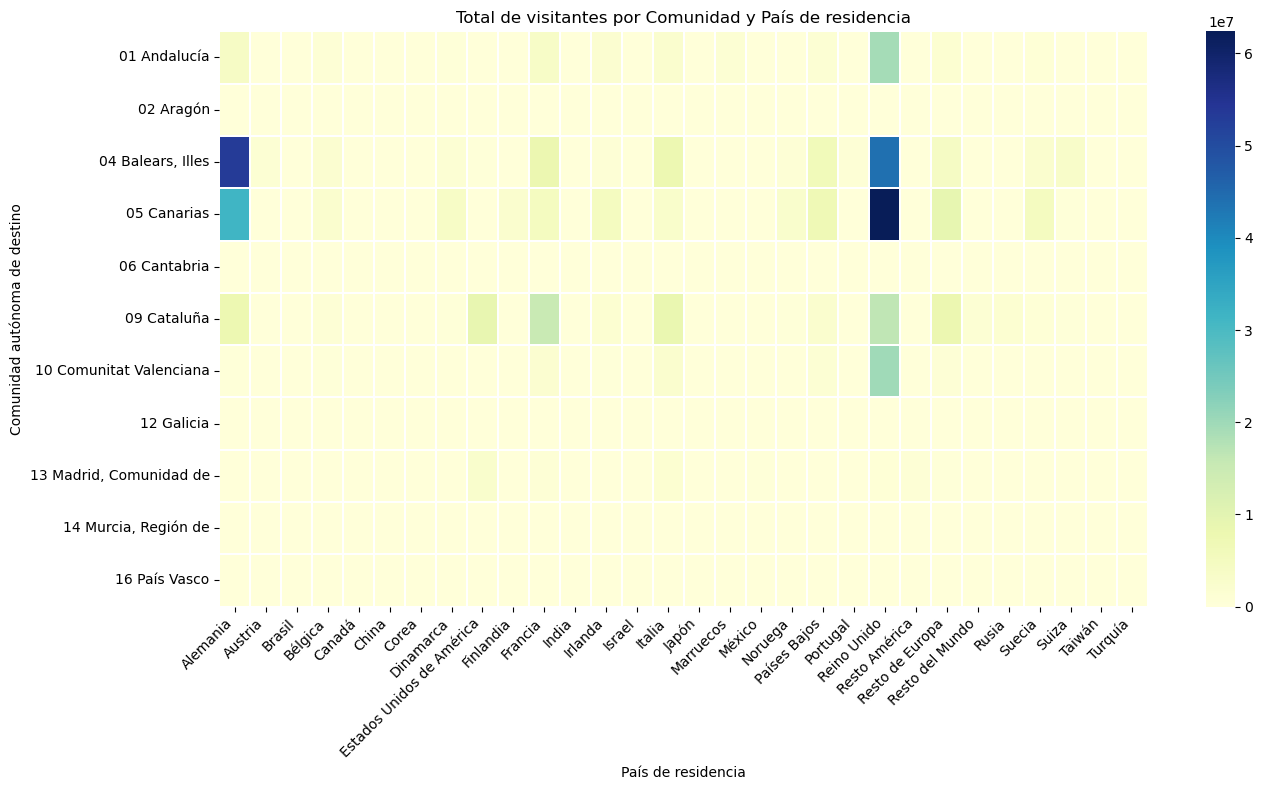

In [35]:
pivot = df.pivot_table(
    index="Comunidad autónoma de destino",
    columns="País de residencia",
    values="Total",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.3)
plt.title("Total de visitantes por Comunidad y País de residencia")
plt.xlabel("País de residencia")
plt.ylabel("Comunidad autónoma de destino")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Se aprecia que Canarias y Baleares si disponen de datos mucho mayores en comparacion con otras comunidades autónomas. 

En los siguientes pasos se realizará un análisis exploratorio mas enfocado en forecasting y en clustering de manera previa al modelado.